In [1]:
import os
os.system("python --version")
import yt
import numpy as np
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import AxesGrid

print(yt.__version__)
os.system("python --version")
yt.set_log_level(40)        
"""
Possible values of set_log_level by increasing level:
        0 or "notset"
        1 or "all"
        10 or "debug"
        20 or "info"
        30 or "warning"
        40 or "error"
        50 or "critical"
"""


# The toggle_interactivity() function toggles interactive jupyter plots

yt.toggle_interactivity()

Python 3.9.18
4.1.4
Python 3.9.18
Using matplotlib backend: agg


In [2]:
## IMPORTING TIME SERIES DATA INTO VARIABLE ts
# scratchPath = "/mnt/scratch/freem386/magpinch_fixed_may1/"
# basename = "magpinch"
scratchPath = "/mnt/gs21/scratch/freem386/new_pgen_magpinch/"
basename = "MPsimple"
f0, fn = 0, 100
step, width = 1, 5 
files = []
for f in np.arange(f0, fn+1, step, dtype=int):
    files.append(scratchPath + basename + ".out2." + str(f).zfill(width) + ".athdf")
print(files)

# unit_base={"length_unit": (1.0,"pc"), "time_unit": (1.0,"s*pc/km"), "mass_unit": (2.38858753789e-24,"g/cm**3*pc**3")}
ts = yt.DatasetSeries(files)
print("number of files: ", len(files))

['/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00000.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00001.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00002.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00003.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00004.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00005.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00006.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00007.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00008.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00009.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00010.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00011.athdf', '/mnt/gs21/scratch/freem386/new_pgen_magpinch/MPsimple.out2.00012.athdf', '/mnt/gs21/scratch/freem386/new_pgen_

In [10]:
## Checking derived or innate field lists
# ds = ts[0]
# ds.derived_field_list
# print(ds.field_list)
# ad = ds.all_data()
# test = np.array(ad[('athena_pp', 'vel1')])

/mnt/home/freem386/anaconda3/envs/research/lib/python3.9/site-packages/unyt/array.py:1906: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(



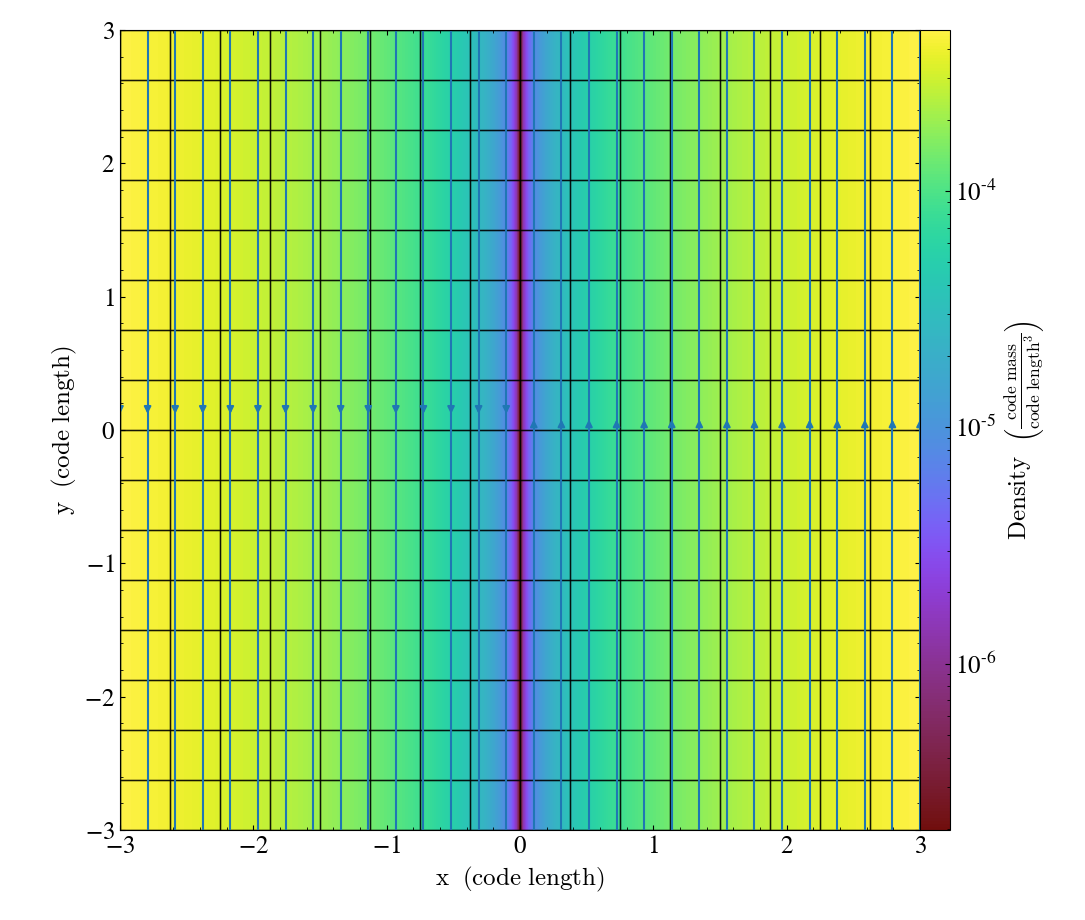

In [41]:
## Plotting a single dataset
index = 0
ds = ts[index]

p = yt.plot_2d(ds, ("gas","density"))
# p = yt.plot_2d(ds, ("gas", "plasma_beta"))
# p = yt.plot_2d(ds, ("gas", "pressure"))
# p = yt.plot_2d(ds, ('gas', 'kT'))
# p = yt.plot_2d(ds, ("gas", "magnetic_pressure"))
# p = yt.plot_2d(ds, ("gas", "velocity_magnitude"))
# p = yt.plot_2d(ds, ("athena_pp", "vel2"))
# p = yt.plot_2d(ds, ("gas", "velocity_magnitude"))
# p = yt.plot_2d(ds, ("gas", "mach_number"))
# p = yt.plot_2d(ds, ("gas", "magnetic_field_y"))
# p = yt.plot_2d(ds, ("gas", "specific_thermal_energy"))

# p.set_zlim(("gas", "density"), zmin=1e-4, zmax=1e5)
p.annotate_grids()

# p.annotate_magnetic_field()
p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"))

# p.annotate_velocity()
# p.annotate_streamlines(("gas", "velocity_x"), ("gas", "velocity_y"))

# p.pan([3, 0])
# p.zoom(1)

# fig = p.export_to_mpl_figure((1,1))
# fig.savefig("pressure_three_looped_fixed_magpinch_1.png")

p

## Field list output from magpinch problems:
('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3'),
('athena_pp', 'cell_volume'),
('athena_pp', 'dx'), ('athena_pp', 'dy'), ('athena_pp', 'dz'),
('athena_pp', 'path_element_x'), ('athena_pp', 'path_element_y'), ('athena_pp', 'path_element_z'),
('athena_pp', 'press'),
('athena_pp', 'rho'),
('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3'),
('athena_pp', 'volume'),
('athena_pp', 'x'), ('athena_pp', 'y'), ('athena_pp', 'z'),
('gas', 'alfven_speed'),
('gas', 'angular_momentum_magnitude'),
('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z'),
('gas', 'averaged_density'),
('gas', 'baroclinic_vorticity_magnitude'),
('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z'),
('gas', 'cell_mass'), ('gas', 'cell_volume'),
('gas', 'courant_time_step'),
('gas', 'density'),
('gas', 'density_gradient_magnitude'), ('gas', 'density_gradient_x'), ('gas', 'density_gradient_y'), ('gas', 'density_gradient_z'),
('gas', 'dx'), ('gas', 'dy'), ('gas', 'dynamical_time'), ('gas', 'dz'),
('gas', 'four_velocity_magnitude'), ('gas', 'four_velocity_t'), ('gas', 'four_velocity_x'), ('gas', 'four_velocity_y'), ('gas', 'four_velocity_z'),
('gas', 'jeans_mass'),
('gas', 'kT'),
('gas', 'kinetic_energy_density'),
('gas', 'lorentz_factor'),
('gas', 'mach_alfven'), ('gas', 'mach_number'),
('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_los'), ('gas', 'magnetic_field_magnitude'),
('gas', 'magnetic_field_strength'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z'),
('gas', 'magnetic_pressure'),
('gas', 'mass'), ('gas', 'mean_molecular_weight'),
('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'), ('gas', 'momentum_density_z'),
('gas', 'momentum_x'), ('gas', 'momentum_y'), ('gas', 'momentum_z'),
('gas', 'number_density'),
('gas', 'path_element_x'), ('gas', 'path_element_y'), ('gas', 'path_element_z'),
('gas', 'plasma_beta'),
('gas', 'pressure'), ('gas', 'pressure_gradient_magnitude'), ('gas', 'pressure_gradient_x'), ('gas', 'pressure_gradient_y'), ('gas', 'pressure_gradient_z'),
('gas', 'relative_magnetic_field_x'), ('gas', 'relative_magnetic_field_y'), ('gas', 'relative_magnetic_field_z'),
('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z'),
('gas', 'shear'), ('gas', 'shear_criterion'), 
('gas', 'shear_mach'), ('gas', 'sound_speed'),
('gas', 'specific_angular_momentum_magnitude'), ('gas', 'specific_angular_momentum_x'), ('gas', 'specific_angular_momentum_y'), ('gas', 'specific_angular_momentum_z'),
('gas', 'specific_thermal_energy'),
('gas', 'temperature'),
('gas', 'velocity_los'),
('gas', 'velocity_magnitude'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z'),
('gas', 'volume'),
('gas', 'vorticity_magnitude'), ('gas', 'vorticity_squared'),
('gas', 'vorticity_x'), ('gas', 'vorticity_y'), ('gas', 'vorticity_z'),
('gas', 'x'), ('gas', 'y'), ('gas', 'z'),
('index', 'cell_volume'),
('index', 'cylindrical_radius'),
('index', 'cylindrical_theta'),
('index', 'cylindrical_z'),
('index', 'dx'), ('index', 'dy'), ('index', 'dz'),
('index', 'grid_indices'), ('index', 'grid_level'),
('index', 'morton_index'),
('index', 'ones'), ('index', 'ones_over_dx'),
('index', 'path_element_x'), ('index', 'path_element_y'), ('index', 'path_element_z'),
('index', 'radius'), ('index', 'spherical_phi'), ('index', 'spherical_radius'), ('index', 'spherical_theta'),
('index', 'virial_radius_fraction'),
('index', 'volume'),
('index', 'x'), ('index', 'y'), ('index', 'z'), 
('index', 'zeros')

In [27]:
## Defining field variables so quickly changing them is easier
Bcc1, Bcc2, Bcc3 = ('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3')
cell_volume = ('athena_pp', 'cell_volume')
dx, dy, dz = ('athena_pp', 'dx'), ('athena_pp', 'dy'), ('athena_pp', 'dz')
path_element_x, path_element_y, path_element_z = ('athena_pp', 'path_element_x'), ('athena_pp', 'path_element_y'), ('athena_pp', 'path_element_z')
press, rho = ('athena_pp', 'press'), ('athena_pp', 'rho')
vel1, vel2, vel3 = ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3')
volume, x, y, z = ('athena_pp', 'volume'), ('athena_pp', 'x'), ('athena_pp', 'y'), ('athena_pp', 'z')
alfven_speed, angular_momentum_magnitude = ('gas', 'alfven_speed'), ('gas', 'angular_momentum_magnitude')
angular_momentum_x, angular_momentum_y, angular_momentum_z = ('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z')
averaged_density, baroclinic_vorticity_magnitude = ('gas', 'averaged_density'), ('gas', 'baroclinic_vorticity_magnitude')
baroclinic_vorticity_x, baroclinic_vorticity_y, baroclinic_vorticity_z = ('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z')
cell_mass, cell_volume = ('gas', 'cell_mass'), ('gas', 'cell_volume')
courant_time_step, density = ('gas', 'courant_time_step'), ('gas', 'density')
density_gradient_magnitude, density_gradient_x, density_gradient_y, density_gradient_z = ('gas', 'density_gradient_magnitude'), ('gas', 'density_gradient_x'), ('gas', 'density_gradient_y'), ('gas', 'density_gradient_z')
dx_gas, dy_gas, dynamical_time, dz_gas = ('gas', 'dx'), ('gas', 'dy'), ('gas', 'dynamical_time'), ('gas', 'dz')
jeans_mass, kT, kinetic_energy_density, lorentz_factor = ('gas', 'jeans_mass'), ('gas', 'kT'), ('gas', 'kinetic_energy_density'), ('gas', 'lorentz_factor')
mach_alfven, mach_number = ('gas', 'mach_alfven'), ('gas', 'mach_number')
magnetic_energy_density, magnetic_field_los, magnetic_field_magnitude = ('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_los'), ('gas', 'magnetic_field_magnitude')
magnetic_field_strength, magnetic_field_x, magnetic_field_y, magnetic_field_z = ('gas', 'magnetic_field_strength'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z')
magnetic_pressure, mass, mean_molecular_weight = ('gas', 'magnetic_pressure'), ('gas', 'mass'), ('gas', 'mean_molecular_weight')
momentum_density_x, momentum_density_y, momentum_density_z = ('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'), ('gas', 'momentum_density_z')
momentum_x, momentum_y, momentum_z = ('gas', 'momentum_x'), ('gas', 'momentum_y'), ('gas', 'momentum_z')
number_density, plamsa_beta = ('gas', 'number_density'), ('gas', 'plasma_beta')
pressure, pressure_gradient_magnitude, pressure_gradient_x, pressure_gradient_y, pressure_gradient_z = ('gas', 'pressure'), ('gas', 'pressure_gradient_magnitude'), ('gas', 'pressure_gradient_x'), ('gas', 'pressure_gradient_y'), ('gas', 'pressure_gradient_z')
relative_magnetic_field_x, relative_magnetic_field_y, relative_magnetic_field_z = ('gas', 'relative_magnetic_field_x'), ('gas', 'relative_magnetic_field_y'), ('gas', 'relative_magnetic_field_z')
relative_velocity_x, relative_velocity_y, relative_velocity_z = ('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z')
shear, shear_criterion, shear_mach, sound_speed = ('gas', 'shear'), ('gas', 'shear_criterion'), ('gas', 'shear_mach'), ('gas', 'sound_speed')
specific_angular_momentum_magnitude, specific_angular_momentum_x, specific_angular_momentum_y, specific_angular_momentum_z = ('gas', 'specific_angular_momentum_magnitude'), ('gas', 'specific_angular_momentum_x'), ('gas', 'specific_angular_momentum_y'), ('gas', 'specific_angular_momentum_z')
specifici_thermal_energy, temperature, velocity_los = ('gas', 'specific_thermal_energy'), ('gas', 'temperature'), ('gas', 'velocity_los')
velocity_magnitude, velocity_x, velocity_y, velocity_z = ('gas', 'velocity_magnitude'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z')
volume, vorticity_magnitude, vorticity_squared = ('gas', 'volume'), ('gas', 'vorticity_magnitude'), ('gas', 'vorticity_squared')
vorticity_x, vorticity_y, vorticity_z = ('gas', 'vorticity_x'), ('gas', 'vorticity_y'), ('gas', 'vorticity_z')
x_gas, y_gas, z_gas = ('gas', 'x'), ('gas', 'y'), ('gas', 'z')

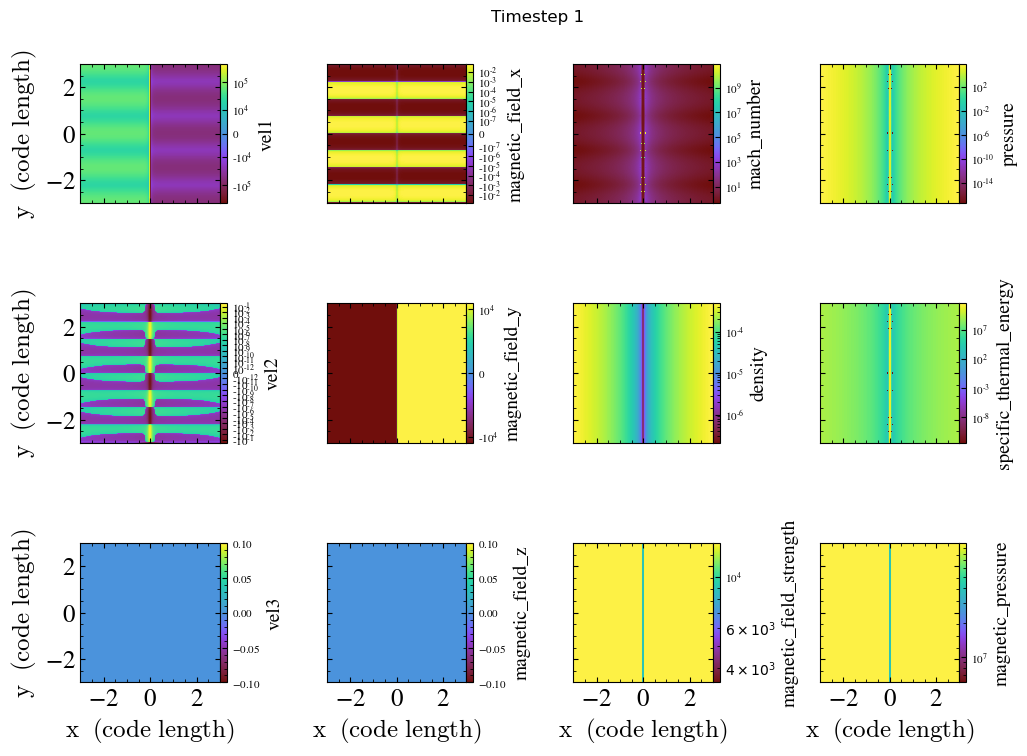

In [26]:
# Choose the dataset index
index = 1
ds = ts[index]

fields = [
    ('athena_pp', 'vel1'), ('gas', 'magnetic_field_x'), ('gas', 'mach_number'),             ('gas', 'pressure'),
    ('athena_pp', 'vel2'), ('gas', 'magnetic_field_y'), ('gas', 'density'),                 ('gas', 'specific_thermal_energy'),
    ('athena_pp', 'vel3'), ('gas', 'magnetic_field_z'), ('gas', 'magnetic_field_strength'), ('gas', 'magnetic_pressure')
]

# Create a SlicePlot
p = yt.SlicePlot(ds, "z", fields)

# Export to a Matplotlib figure
fig = p.export_to_mpl_figure((3, 4))
fig.suptitle("Timestep " + str(index))

# Adjust the layout
fig.tight_layout(rect=[0, 0, 1, 1.2])  # Adjust rect to prevent overlap with suptitle
fig.subplots_adjust(wspace=0.05, hspace=0.01)  # Set small values for minimal spacing

# Iterate over each axis in the figure to modify the colorbar labels
for ax, field in zip(fig.axes, fields):
    if hasattr(ax, 'images') and ax.images:
        img = ax.images[0]
        cbar = img.colorbar
        if cbar is not None:
            # Set the font size for the colorbar labels
            cbar.ax.tick_params(labelsize=8)
            # Set the custom label for the colorbar
            cbar.set_label(field[1], fontsize=14)

# Save the figure or display it
# fig.savefig("magpinchsimple_time_series_test_may_24.png")
fig

In [25]:
plt.close("all")